In [1]:
# packages needed to be installed on google colab
!pip install -q -U einops datasets matplotlib tqdm

import torch
from torch import nn, einsum
import torch.nn.functional as F
import numpy as np
import math
from einops import rearrange
from tqdm.auto import tqdm

## Defining the forward diffusion process - Noise Scheduler

We first need to build the inputs for our model, which are more and more noisy images. Instead of doing this sequentially, we can use the closed form provided in the papers to calculate the image for any of the timesteps individually.

The forward diffusion process gradually adds noise to an image from the real distribution, in a number of time steps T. This happens according to a variance schedule. The original DDPM authors employed a linear schedule:

> We set the forward process variances to constants increasing linearly from  𝛽1=1e−4  to  𝛽𝑇=0.02

However, it was shown in (Nichol et al., 2021) that better results can be achieved when employing a cosine schedule.

Key Takeaways:

- The noise-levels/variances can be pre-computed
- There are different types of variance schedules
- We can sample each timestep image independently (Sums of Gaussians is also Gaussian)
- No model is needed in this forward step

Defining various variance schedules below:

In [2]:
# functions for various variance schedules
def linear_beta_schedule(timesteps, beta_start = 0.0001, beta_end = 0.02):
    """ linear schedule as used in the ddpm paper """
    return torch.linspace(beta_start, beta_end, timesteps)

def cosine_beta_schedule(timesteps, s=0.008):
    """ cosine schedule as proposed in https://arxiv.org/abs/2102.09672 """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)

def quadratic_beta_schedule(timesteps, beta_start = 0.0001, beta_end = 0.02):
    return torch.linspace(beta_start**0.5, beta_end**0.5, timesteps) ** 2

def sigmoid_beta_schedule(timesteps, beta_start = 0.0001, beta_end = 0.02):
    betas = torch.linspace(-6, 6, timesteps)
    return torch.sigmoid(betas) * (beta_end - beta_start) + beta_start

To start with, let's use the linear schedule for T = 250  time steps and define the various variables from the beta_t which we will need, such as the cumulative product of the variances alpha_bar_t

In [3]:
timesteps = 250

# defining beta schedule
betas = linear_beta_schedule(timesteps=timesteps)

# pre-calculating different terms for closed form
# each of the variables below are just 1-dimensional tensors, storing values from t to T
## defining alphas
alphas = 1. - betas
alpha_cum_prod = torch.cumprod(alphas, axis=0)
alpha_cum_prod_prev = F.pad(alpha_cum_prod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

## calculations for diffusion q(x_t | x_{t-1}) and others
sqrt_alpha_cum_prod = torch.sqrt(alpha_cum_prod)
sqrt_one_minus_alpha_cum_prod = torch.sqrt(1. - alpha_cum_prod)

## calculations for posterior q(x_{t-1} | x_t, x_0)
posterior_variance = betas * (1. - alpha_cum_prod_prev) / (1. - alpha_cum_prod)

def extract_index(vals, t, x_shape):
    """ returns the appropriate index t for a batch of indices """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

Checking how noise is added at each time step of the forward diffusion process by illustrating it on cute dog image

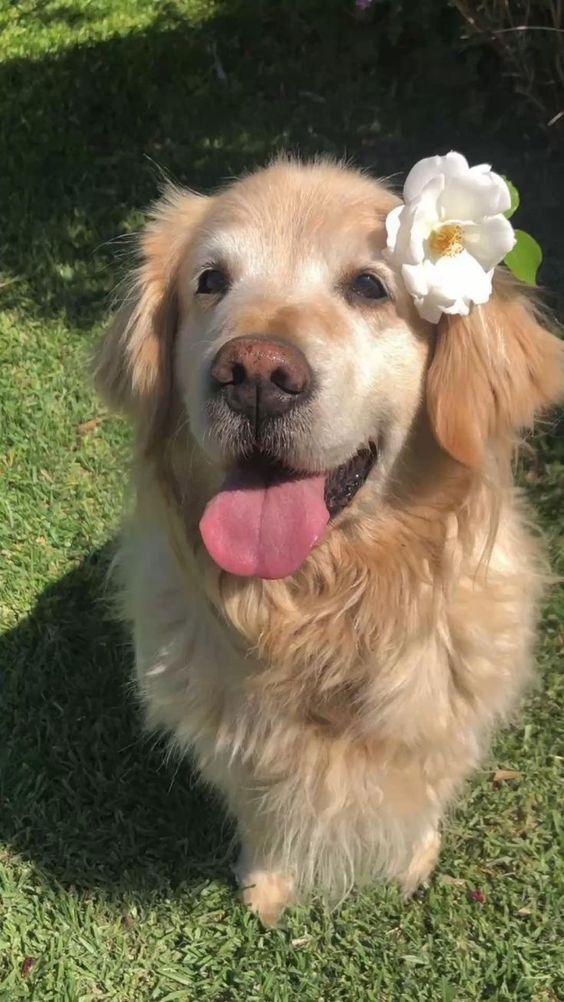

In [4]:
from PIL import Image
import requests
url = "https://i.pinimg.com/564x/3a/c9/84/3ac98429250196dcdf4fe874891c63bf.jpg"
image = Image.open(requests.get(url, stream=True).raw)
image

Defining image transformations that allow us to go from a PIL image to a PyTorch tensor (as noise is added to PyTorch tensors rather than Pillow images)

These transformations are fairly simple: we first normalize images by dividing by  255  (such that they are in the  [0,1]  range), and then make sure they are in the  [−1,1]  range. From the DPPM paper:

> We assume that image data consists of integers in  {0,1,...,255}  scaled linearly to  [−1,1] . This ensures that the neural network reverse process operates on consistently scaled inputs starting from the standard normal prior  𝑝(𝐱𝑇) .

In [5]:
from torchvision.transforms import Compose,  Resize, CenterCrop, ToTensor, Lambda

image_size = 128
transform = Compose([
    Resize(image_size), # resizing the input image
    CenterCrop(image_size),
    ToTensor(), # scales data into [0,1] (turns into torch tensor of shape HWC, divide by 255)
    Lambda(lambda t: (t * 2) - 1), # scales data to be between [-1, 1]
])

x_0 = transform(image).unsqueeze(0)
x_0.shape

torch.Size([1, 3, 128, 128])

Defining the reverse image transformation, which takes in a PyTorch tensor containing values in  [−1,1]  and turn them back into a PIL image

In [6]:
from torchvision.transforms import ToPILImage

reverse_transform = Compose([
     Lambda(lambda t: (t + 1) / 2), # scales data to be between [0, 1]
     Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
     Lambda(lambda t: t * 255.), # scales data to be between [0., 255.]
     Lambda(lambda t: t.numpy().astype(np.uint8)), # converts into an uint8 numpy array
     ToPILImage(), # converts to PIL image
])

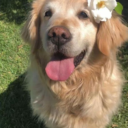

In [7]:
reverse_transform(x_0.squeeze())

Defining the forward diffusion process as done in the DDPM paper

In [8]:
def q_sample(x_0: torch.tensor, t, noise=None):
    """ forward diffusion process """

    if noise is None:
        noise = torch.randn_like(x_0)

    sqrt_alpha_cum_prod_t = extract_index(sqrt_alpha_cum_prod, t, x_0.shape)
    sqrt_one_minus_alpha_cum_prod_t = extract_index(sqrt_one_minus_alpha_cum_prod, t, x_0.shape)

    # mean + variance
    return sqrt_alpha_cum_prod_t * x_0 + sqrt_one_minus_alpha_cum_prod_t * noise

def get_noisy_image(x_0, t):
  """
  takes an image and a timestep as input and returns the noisy version of it
  x_0: (batch_size, num_channels, height, width)
  t: (batch_size,)
  """

  x_noisy = q_sample(x_0, t=t) # adding noise
  noisy_image = reverse_transform(x_noisy.squeeze())  # turning back into PIL image

  return noisy_image

Testing it on a particular time step

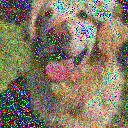

In [9]:
t = torch.tensor([42])
get_noisy_image(x_0, t)

Let's visualize this for various time steps

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

# seed for reproducability
torch.manual_seed(42)

def plot(imgs):
    if not isinstance(imgs[0], list):
        # making a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0])
    fig, axs = plt.subplots(figsize=(200,200), nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img))
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    plt.tight_layout()

In [11]:
plot([get_noisy_image(x_0, torch.tensor([t])) for t in [0, 42, 69, 100, 150, 200]])

## Defining the reverse diffusion process - Building blocks for U-Net

### Position embeddings
As the parameters of the neural network are shared across time (noise level), the authors employ sinusoidal position embeddings to encode t , inspired by the Transformer (Vaswani et al., 2017). This makes the neural network "know" at which particular time step (noise level) it is operating, for every image in a batch.

The SinusoidalPositionEmbeddings module takes a tensor of shape (batch_size, 1) as input (i.e. the noise levels of several noisy images in a batch), and turns this into a tensor of shape (batch_size, dim), with dim being the dimensionality of the position embeddings. This is then added to each residual block

In [12]:
class SinusoidalPositionEmbeddings(nn.Module):
    """
    sin(pos/(10000^(2i/d_model))
    cos(pos/(10000^(2i/d_model))
    """

    def __init__(self, dim: int):
        super().__init__()
        self.dim = dim

    def forward(self, timesteps: int):
        device = timesteps.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = timesteps[:, None] * embeddings[None, :] # timesteps B -> B, 1 -> B, time_embedding_dimension
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

### ResNet block
Defining the core building block of the U-Net model, i.e. a ResNet block like the DDPM authors employed

In [13]:
class Block(nn.Module):
    def __init__(self, dim: int, dim_out: int, groups: int = 8):
        super().__init__()
        self.proj = nn.Conv2d(in_channels=dim, out_channels=dim_out, kernel_size=3, stride=1, padding=1)
        self.norm = nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()

    def forward(self, x: torch.tensor):
        x = self.proj(x)
        x = self.norm(x)
        x = self.act(x)
        return x

class ResNetBlock(nn.Module):
    """ ResNet Block: https://arxiv.org/abs/1512.03385"""

    def __init__(self, dim: int, dim_out: int, time_emb_dim = None, groups: int = 8):
        super().__init__()
        self.time_mlp = (nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_emb_dim, dim_out))
            if time_emb_dim else None
            )

        self.resnet_conv_first = Block(dim, dim_out, groups=groups)
        self.resnet_conv_second = Block(dim_out, dim_out, groups=groups)
        self.residual_input_conv = nn.Conv2d(in_channels=dim, out_channels=dim_out, kernel_size=1)  if dim != dim_out else nn.Identity()

    def forward(self, x: torch.tensor, time_emb = None):
        h = self.resnet_conv_first(x)

        if self.time_mlp:
            time_emb = self.time_mlp(time_emb)
            time_emb = rearrange(time_emb, "b c -> b c 1 1") # extending last two dimensions
            h = h + time_emb # adding time channel

        h = self.resnet_conv_second(h)
        h = h + self.residual_input_conv(x)
        return h

## Attention module
Defining the attention module which the DDPM authors added in between the convolutional blocks

In [14]:
class MultiHeadAttention(nn.Module):
    """ multiple heads of self attention in parallel """

    def __init__(self, dim: int, num_heads: int = 4, head_size: int = 32):
        super().__init__()
        self.scale = head_size**-0.5
        self.num_heads = num_heads
        hidden_dim = head_size * num_heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x: torch.tensor):
        b, c, h, w = x.shape # batch_size, num_channels, height, width
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map( # queries, keys, values
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.num_heads), qkv
        )
        q = q * self.scale

        # https://rockt.github.io/2018/04/30/einsum
        sim = einsum("b h d i, b h d j -> b h i j", q, k)
        sim = sim - sim.amax(dim=-1, keepdim=True).detach()
        attention_scores = sim.softmax(dim=-1)

        out = einsum("b h i j, b h d j -> b h i d", attention_scores, v)
        out = rearrange(out, "b h (x y) d -> b (h d) x y", x=h, y=w)
        return self.to_out(out)

## Group normalizaiton
The DDPM authors interleave the convolutional/attention layers of the U-Net with group normalization
https://arxiv.org/abs/1803.08494

In [15]:
class PreNorm(nn.Module):
    """ PreNorm class which will be used to apply groupnorm before the attention layer """

    def __init__(self, dim: int, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.GroupNorm(1, dim) # puts all dim channels into a single group (equivalent with LayerNorm)

    def forward(self, x: torch.tensor):
        x = self.norm(x) # applying group normalization
        return self.fn(x)

## Network helpers
Defining some helper functions and classes which will be used when implementing the neural network (U-Net)


In [16]:
class Residual(nn.Module):
    """ adds a residual connection to a particular function """

    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x # adding the input to the output of a particular function

def Upsample(dim):
    """ upsamling opertaion """

    return nn.ConvTranspose2d(dim, dim, 4, 2, 1)

def Downsample(dim):
    """ downsampling operation """

    return nn.Conv2d(dim, dim, 4, 2, 1)

 ## U-Net (Unconditional)
Now that we've defined all building blocks (position embeddings, ResNet blocks, attention), it's time to define the entire neural network. Recall that the job of the network  𝜖𝜃(𝐱𝑡,𝑡)  is to take in a batch of noisy images + noise levels, and output the noise added to the input. More formally:
    
- the network takes a batch of noisy images of shape (batch_size, num_channels, height, width) and a batch of noise levels of shape (batch_size, 1) as input, and returns a tensor of shape (batch_size, num_channels, height, width)
    
The network is built up as follows:
    
- first, a convolutional layer is applied on the batch of noisy images, and position embeddings are computed for the noise levels
- next, a sequence of downsampling stages are applied. Each downsampling stage consists of 2 ResNet blocks + groupnorm + attention + residual connection + a downsample operation
- at the middle of the network, again ResNet blocks are applied, interleaved with attention
- next, a sequence of upsampling stages are applied. Each upsampling stage consists of 2 ResNet blocks + groupnorm + attention + residual connection + an upsample operation
- finally, a ResNet block followed by a convolutional layer is applied

In [17]:
class UNet(nn.Module):
    """ neural network for the reverse diffusion process """

    def __init__(
            self,
            dim: int,
            initial_projection_dim: int = None,
            out_dim: int = None,
            down_channels = [32, 64, 128, 256],
            image_channels: int = 3,
            time_dim: int = 128,
            resnet_block_groups: int = 8
        ):
        super().__init__()

        self.image_channels = image_channels # image channels

        # initial projection layer
        initial_projection_dim = initial_projection_dim if initial_projection_dim else (dim // 3 * 2)
        self.initial_conv = nn.Conv2d(image_channels, initial_projection_dim, kernel_size=7, stride=1, padding=3)

        dims = [initial_projection_dim] + down_channels
        in_out = list(zip(dims[:-1], dims[1:]))

        # time embeddings
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(dim),
            nn.Linear(dim, time_dim),
            nn.SiLU(),
            nn.Linear(time_dim, time_dim),
        )

        # layers
        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)

        # down blocks
        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(
                nn.ModuleList(
                    [
                        ResNetBlock(dim_in, dim_out, time_emb_dim=time_dim, groups=resnet_block_groups),
                        ResNetBlock(dim_out, dim_out, time_emb_dim=time_dim, groups=resnet_block_groups),
                        Residual(PreNorm(dim_out, MultiHeadAttention(dim_out))),
                        Downsample(dim_out) if not is_last else nn.Identity(),
                    ]
                )
            )

        # mid blocks
        mid_dim = dims[-1]
        self.mid_block1 = ResNetBlock(mid_dim, mid_dim, time_emb_dim=time_dim, groups=resnet_block_groups)
        self.mid_attention = Residual(PreNorm(mid_dim, MultiHeadAttention(mid_dim)))
        self.mid_block2 = ResNetBlock(mid_dim, mid_dim, time_emb_dim=time_dim, groups=resnet_block_groups)

        # up blocks
        for ind, (dim_in, dim_out) in enumerate(reversed(in_out[1:])):
            is_last = ind >= (num_resolutions - 1)

            self.ups.append(
                nn.ModuleList(
                    [
                        ResNetBlock(dim_out * 2, dim_in, time_emb_dim=time_dim, groups=resnet_block_groups),
                        ResNetBlock(dim_in, dim_in, time_emb_dim=time_dim, groups=resnet_block_groups),
                        Residual(PreNorm(dim_in, MultiHeadAttention(dim_in))),
                        Upsample(dim_in) if not is_last else nn.Identity(),
                    ]
                )
            )

        out_dim = out_dim if out_dim else image_channels
        self.final_convolution = nn.Conv2d(dim, out_dim, 1)

    def forward(self, x: torch.tensor, t):
        """
        x is is torch tensor of shape (batch_size, num_channels, height, width)
        t is a batch of noise levels of shape (batch_size, 1)
        returns a tensor of shape (batch_size, num_channels, height, width)
        """

        x = self.initial_conv(x) # initial projection
        t = self.time_mlp(t) # embedd time
        residuals = []

        # downsample
        for block1, block2, attention, downsample in self.downs:
            x = block1(x, t)
            x = block2(x, t)
            x = attention(x)
            residuals.append(x)
            x = downsample(x)

        # bottleneck
        x = self.mid_block1(x, t)
        x = self.mid_attention(x)
        x = self.mid_block2(x, t)

        # upsample
        for block1, block2, attention, upsample in self.ups:
            x = torch.cat((x, residuals.pop()), dim=1)
            x = block1(x, t)
            x = block2(x, t)
            x = attention(x)
            x = upsample(x)

        return self.final_convolution(x)

In [18]:
model = UNet(dim=32, image_channels=3, down_channels=[32, 64, 128, 256], time_dim=128)
print("number of parameters: ", sum(p.numel() for p in model.parameters()))
model

number of parameters:  8053299


UNet(
  (initial_conv): Conv2d(3, 20, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=32, out_features=128, bias=True)
    (2): SiLU()
    (3): Linear(in_features=128, out_features=128, bias=True)
  )
  (downs): ModuleList(
    (0): ModuleList(
      (0): ResNetBlock(
        (time_mlp): Sequential(
          (0): SiLU()
          (1): Linear(in_features=128, out_features=32, bias=True)
        )
        (resnet_conv_first): Block(
          (proj): Conv2d(20, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm): GroupNorm(8, 32, eps=1e-05, affine=True)
          (act): SiLU()
        )
        (resnet_conv_second): Block(
          (proj): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm): GroupNorm(8, 32, eps=1e-05, affine=True)
          (act): SiLU()
        )
        (residual_input_conv): Conv2d(20, 32, kernel_size=(1, 1), stride=(1,

## Defining the loss function

In [19]:
def p_losses(denoise_model: torch.nn.Module, x_0: torch.tensor, t, noise=None):
    """ function to calculate huber loss between the true and predicted noise """

    if noise is None:
        noise = torch.randn_like(x_0)

    x_noisy = q_sample(x_0, t, noise) # adding noise to clean images according to the noise magnitude at each timestep
    predicted_noise = denoise_model(x_noisy, t) # getting the model prediction
    loss = F.smooth_l1_loss(noise, predicted_noise) # calculating the huber loss

    return loss

## Defining the sampling function
We'll sample from the model during training (in order to track progress).
In the DDPM paper, sampling is summarized as Algorithm 2.

Generating new images from a diffusion model happens by reversing the diffusion process: we start from $T$, where we sample pure noise from a Gaussian distribution, and then use our neural network to gradually denoise it (using the conditional probability it has learned), until we end up at time step $t = 0$. We can derive a slighly less denoised image $\mathbf{x}_{t-1 }$ by plugging in the reparametrization of the mean, using our noise predictor. Remember that the variance is known ahead of time.

Ideally, we end up with an image that looks like it came from the real data distribution.

In [52]:
@torch.no_grad() # adding @torch.no_grad() to avoid running out of memory
def p_sample(model: torch.nn.Module, x: torch.tensor, t: int, t_index: int):
    x_shape = x.shape
    betas_t = extract_index(betas, t, x_shape)
    sqrt_one_minus_alpha_cum_prod_t = extract_index(sqrt_one_minus_alpha_cum_prod, t, x_shape)
    sqrt_recip_alphas_t = extract_index(sqrt_recip_alphas, t, x_shape)

    # using our noise predictor model to predict the mean
    # equation 11 in the DDPM paper
    model_mean = sqrt_recip_alphas_t * (x - betas_t * model(x, t) / sqrt_one_minus_alpha_cum_prod_t)

    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract_index(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        # line 4 algorithm 2 from the DDPM paper
        return model_mean + torch.sqrt(posterior_variance_t) * noise

# applying algorithm 2 from the DDPM paper and saving all the images
@torch.no_grad()
def sample(model: torch.nn.Module, batch_size: int, image_size: int, image_channels: int):
    device = next(model.parameters()).device

    # starting from pure noise (for each example in the batch)
    image = torch.randn((batch_size, image_channels, image_size, image_size), device=device)
    images = []

    # sampling loop
    for i in reversed(range(0, timesteps)):
        image = p_sample(model, image, torch.full((batch_size,), i, device=device, dtype=torch.long), i)
        images.append(image.cpu())
    return images

## Defining the dataset and dataloader

In [53]:
from datasets import load_dataset

dataset = load_dataset("huggan/smithsonian_butterflies_subset", split="train")
image_size = 32
image_channels = 3
batch_size = 64

Repo card metadata block was not found. Setting CardData to empty.


In [54]:
dataset

Dataset({
    features: ['image_url', 'image_alt', 'id', 'name', 'scientific_name', 'gender', 'taxonomy', 'region', 'locality', 'date', 'usnm_no', 'guid', 'edan_url', 'source', 'stage', 'image', 'image_hash', 'sim_score'],
    num_rows: 1000
})

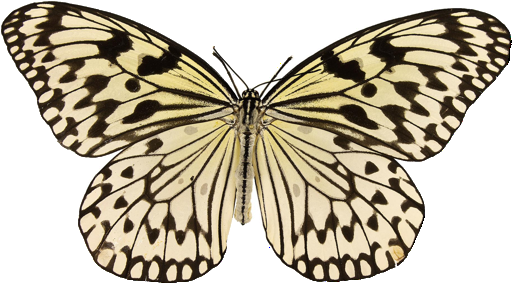

In [55]:
dataset['image'][0]

In [56]:
from torchvision import transforms
from torch.utils.data import DataLoader

# defining our preprocessing pipeline (image transformations/data augmentation)
preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)), # resizing all the images to be of the same size
        transforms.RandomHorizontalFlip(), # random horizontal flips as done by the DDPM authors
        transforms.ToTensor(), # converting to tensor (0, 1)
        transforms.Lambda(lambda t: (t * 2) - 1), # mapping to (-1, 1)
    ]
)

def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}

dataset.set_transform(transform)

# creating a dataloader from the dataset to serve up the transformed images in batches
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [57]:
batch = next(iter(dataloader))["images"][:8]
print("batch shape", batch.shape)

batch shape torch.Size([8, 3, 32, 32])


In [58]:
from torchvision.utils import make_grid

def show_images(x):
    """ given a batch of images x, make a grid and convert to PIL """
    x = x * 0.5 + 0.5  # Map from (-1, 1) back to (0, 1)
    grid = make_grid(x)
    grid_im = grid.detach().cpu().permute(1, 2, 0).clip(0, 1) * 255
    grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))
    return grid_im

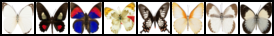

In [59]:
show_images(batch)

## Training the model

In [78]:
from pathlib import Path

def num_to_groups(num, divisor):
    groups = num // divisor
    remainder = num % divisor
    arr = [divisor] * groups
    if remainder > 0:
        arr.append(remainder)
    return arr

results_folder = Path("./generated_images")
results_folder.mkdir(exist_ok = True)
sample_and_save_every = 5

In [79]:
from torch.optim import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"

# defining the model and moving it to GPU
model = UNet(
    dim=image_size,
    image_channels=image_channels,
    down_channels = [32, 64, 128, 256],
    time_dim=128
)
model.to(device)

# defining a standard optimizer (Adam)
optimizer = Adam(model.parameters(), lr=4e-4)

In [80]:
print("number of parameters: ", sum(p.numel() for p in model.parameters()))
model

number of parameters:  8053299


UNet(
  (initial_conv): Conv2d(3, 20, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=32, out_features=128, bias=True)
    (2): SiLU()
    (3): Linear(in_features=128, out_features=128, bias=True)
  )
  (downs): ModuleList(
    (0): ModuleList(
      (0): ResNetBlock(
        (time_mlp): Sequential(
          (0): SiLU()
          (1): Linear(in_features=128, out_features=32, bias=True)
        )
        (resnet_conv_first): Block(
          (proj): Conv2d(20, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm): GroupNorm(8, 32, eps=1e-05, affine=True)
          (act): SiLU()
        )
        (resnet_conv_second): Block(
          (proj): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm): GroupNorm(8, 32, eps=1e-05, affine=True)
          (act): SiLU()
        )
        (residual_input_conv): Conv2d(20, 32, kernel_size=(1, 1), stride=(1,

In [81]:
from torchvision.utils import save_image

epochs = 50
losses = []

for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
      optimizer.zero_grad()

      batch_size = batch["images"].shape[0]
      batch = batch["images"].to(device)

      # Algorithm 1 line 3: sample t uniformally for every example in the batch
      # sampling noise to add to the images
      t = torch.randint(0, timesteps, (batch_size,), device=device).long()

      loss = p_losses(model, batch, t)

      loss.backward()
      losses.append(loss.item())
      optimizer.step()

      # saving some generated images
      if (epoch + 1) % 10 == 0 and step != 0 and step % sample_and_save_every == 0:
        milestone = step // sample_and_save_every
        batches = num_to_groups(4, batch_size)
        all_images_list = list(map(lambda n: sample(model, batch_size=n, image_size=image_size, image_channels=image_channels), batches))
        all_images = torch.cat(all_images_list[0], dim=0)
        all_images = (all_images + 1) * 0.5
        save_image(all_images, str(results_folder / f'epoch-{epoch + 1}-sample-{milestone}.png'), nrow = 10)

    # printing the loss every 5 epochs
    if (epoch + 1) % 5 == 0:
        loss_last_epoch = sum(losses[-len(dataloader) :]) / len(dataloader)
        print(f"Epoch:{epoch+1}, loss: {loss_last_epoch}")

model_checkpoint = Path("./model_checkpoint")
model_checkpoint.mkdir(exist_ok = True)
torch.save(model.state_dict(), str(model_checkpoint / f"model_checkpoint.pt"))

Epoch:5, loss: 0.17245260998606682
Epoch:10, loss: 0.08360812580212951
Epoch:15, loss: 0.06350021040998399
Epoch:20, loss: 0.05288802715949714
Epoch:25, loss: 0.04672717512585223
Epoch:30, loss: 0.04185779229737818
Epoch:35, loss: 0.04015832662116736
Epoch:40, loss: 0.0435864997562021
Epoch:45, loss: 0.03672315808944404
Epoch:50, loss: 0.03665480250492692


## Plotting the loss

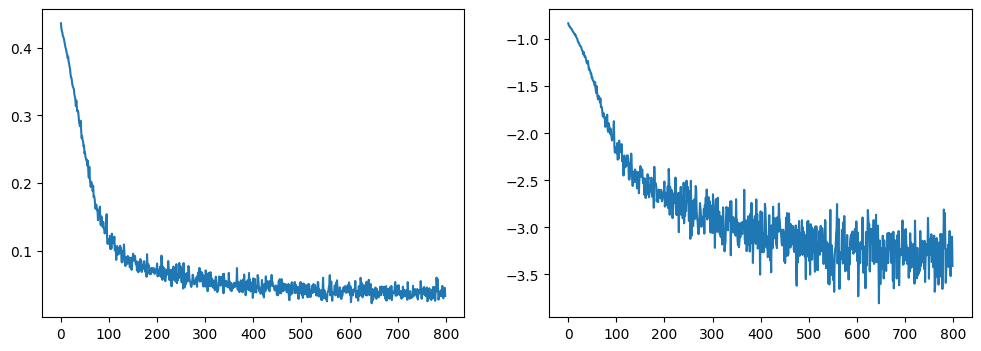

In [82]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(losses)
axs[1].plot(np.log(losses))
plt.show()

we can see that the model rapidly improves initially and then continues to get better at a slower rate, which is more obvious in the log scale plot on the right